In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input
from collections import deque, Counter
import random
from datetime import datetime

In [2]:
### Globals that need to change to switch games. Might also need to adjust math for preprocess_observation below
GAME = "MsPacman-v0"
DIMENSIONS = (88,80,1)
DIMENSIONS_NONE = (None, 88,80,1)
DIMENSIONS_NEG = (-1, 88, 80, 1)

In [3]:
color = np.array([210, 164, 74]).mean()
#Preprocessing function for input screens, croping them to rigght size and 
#turning them into a greyscale 1D tensor
def preprocess_observation(obs):

  # Crop and resize the image
  img = obs[1:176:2, ::2]

  # Convert the image to greyscale
  img = img.mean(axis=2)

  # Improve image contrast
  img[img==color] = 0

  # Next we normalize the image from -1 to +1
  img = (img - 128) / 128 - 1

  return img.reshape(DIMENSIONS)

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


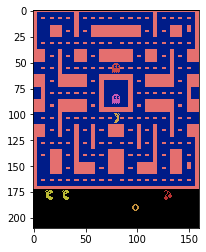

In [4]:
#initialize gym game and looc at size and actions of game
env = gym.make(GAME)
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observations = env.reset()

for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)

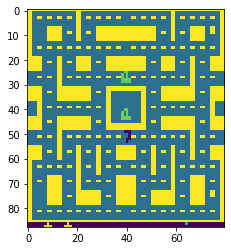

(210, 160, 3)
(88, 80)


In [5]:
#Preprocessed image (No Mrs. Pacman)
#Print the original and preprocessed tensors.

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

In [6]:
def q_network(learning_rate):
  
  
  model = tf.keras.Sequential([
       Input(shape=DIMENSIONS),
       Conv2D(32, (8,8), strides=4, padding='SAME'),
       Conv2D(64, (4,4), strides=2, padding='SAME'),
       Conv2D(64, (3,3), strides=1, padding='SAME'),
       Flatten(),
       Dense(128),
       Dense(n_outputs)                    
  ])
  tf.summary.histogram('layer_1', model.layers[0])
  tf.summary.histogram('layer_2', model.layers[1])
  tf.summary.histogram('layer_3', model.layers[2])
  tf.summary.histogram('fc', model.layers[4])
  tf.summary.histogram('output', model.layers[5])
  
  model.compile(tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())

  return model

In [7]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [8]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

In [9]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [10]:
num_episodes = 800
batch_size = 48
input_shape =DIMENSIONS_NONE
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = DIMENSIONS_NONE
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [11]:
logdir = 'logs'

X =tf.keras.Input(shape=X_shape, name="X")

in_training_mode = tf.Variable(initial_value=False,dtype=tf.bool)


In [12]:

mainQ = q_network(learning_rate)

targetQ = q_network(learning_rate)

In [13]:
X_action = tf.Variable(0,dtype=tf.int32) #Might need to fix the shape


In [15]:
# for each episode
history = []
for i in range(num_episodes):
    done = False
    obs = env.reset()
    epoch = 0
    episodic_reward = 0
    actions_counter = Counter() 
    episodic_loss = []

    # while the state is not the terminal state
    while not done:

        #env.render()
        
        # get the preprocessed game screen
        obs = preprocess_observation(obs)

        # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
        actions = mainQ.predict(x=obs.reshape(DIMENSIONS_NEG))
        # actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
            
        # now perform the action and move to the next state, next_obs, receive reward
        next_obs, reward, done, _ = env.step(action)

        # Store this transistion as an experience in the replay buffer! Quite important
        exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
        # After certain steps, we train our Q network with samples from the experience replay buffer
        if global_step % steps_train == 0 and global_step > start_steps:
                
            # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
            o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

            # states
            o_obs = [x for x in o_obs]

            # next states
            o_next_obs = [x for x in o_next_obs]

            # next actions
            next_act = [mainQ.predict(x=o.reshape(DIMENSIONS_NEG)) for o in o_next_obs]

            # discounted reward: these are our Y-values
            y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

            
        # after some interval we copy our main Q network weights to target Q network
        if (global_step+1) % copy_steps == 0 and global_step > start_steps:
            mainQ = tf.keras.models.clone_model(targetQ)
                
        obs = next_obs
        epoch += 1
        global_step += 1
        episodic_reward += reward
        
    history.append(episodic_reward)
    print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

KeyboardInterrupt: 